In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
import xgboost
import shap

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold , KFold

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,20))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [8]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [10]:
SEED = 43

In [11]:
target = 'next_PM10'

Train : 2021년 데이터셋  
Test : 2022년 데이터셋

In [13]:
train = pd.read_csv("data_pm/train_1.csv")
train.dropna(inplace=True)

test = pd.read_csv("data_pm/test_1.csv")
test.dropna(inplace=True)

In [14]:
try:
    x_train = train.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
    y_train = train.loc[:, target]

    x_val = test.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
    y_val = test.loc[:, target]
except:
    x_train = train.drop([target], axis = 1) #제거할 때, date도 제거
    y_train = train.loc[:, target]

    x_val = test.drop([target], axis = 1) #제거할 때, date도 제거
    y_val = test.loc[:, target]

In [15]:
x_train.shape , y_train.shape, x_val.shape, y_val.shape

((8758, 91), (8758,), (2161, 91), (2161,))

In [16]:
import copy
answer = copy.deepcopy(x_val)

datetimes = []
for idx, row in answer.iterrows():
    y, m, d, h = int(row['year']), int(row['month']), int(row['day']), int(row['hour'])
    datetimes += [pd.to_datetime("%04d%02d%02d%02d" % (y, m, d, h), format='%Y%m%d%H')]
answer['date'] = datetimes
answer['next_PM10'] = y_val.tolist()

answer = answer.set_index('date')

In [17]:
x_train = x_train.drop(['day', 'year','month'], axis = 1)
x_val = x_val.drop(['day', 'year', 'month'], axis = 1)

In [18]:
x_train.shape

(8758, 88)

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(x_train)

train_feature_scaled = scaler.transform(x_train)
val_feature_scaled = scaler.transform(x_val)

pca = PCA(n_components=24)
pca.fit(train_feature_scaled)

x_train_re = pca.transform(train_feature_scaled)
x_val_re = pca.transform(val_feature_scaled)

---

### **LinearRegression**

In [20]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [21]:
pred = model.predict(x_val)

In [22]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 3.88912559620515
MSE : 35.33794367249298
RMSE : 5.9445726231995
MAPE : 0.12206557891746535 

R2 Score : 0.9360778178856305
1-MAPE : 0.8779344210825346


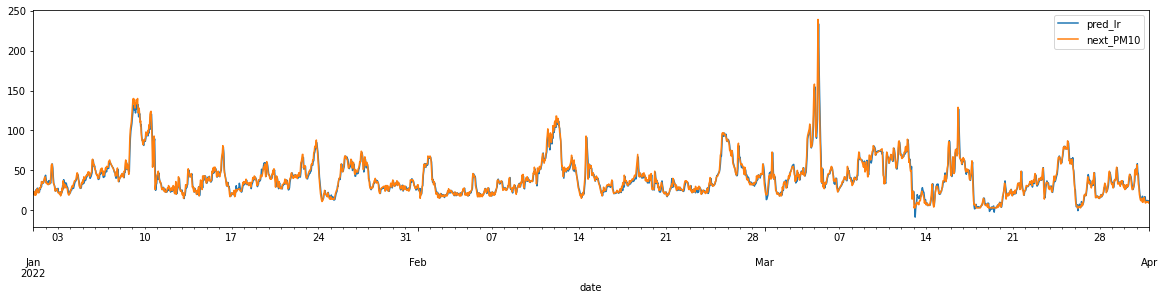

In [23]:
answer['pred_lr'] = pred
answer[['pred_lr', 'next_PM10']]['2022'].plot(figsize=(20,4))

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


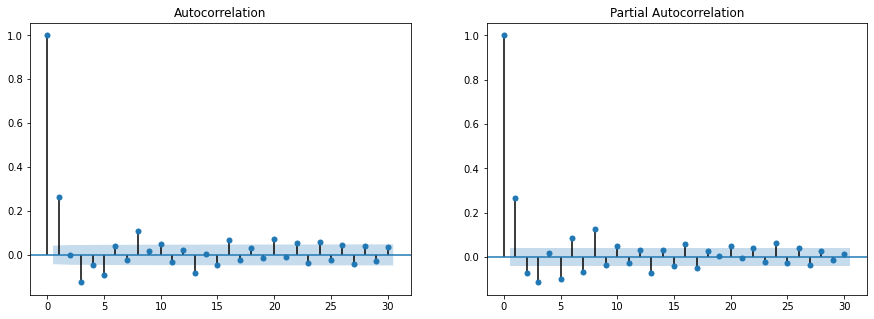

In [24]:
# 현 시점 residual과 한 시간 전 residual은 굉장히 상관 있음
# 다른 패턴은 안보임

residual = answer['next_PM10'] - answer['pred_lr'] 
residual_diag(residual)

### **DT**

In [25]:
depth = list(range(3, 55))
r2 = []
for d in depth :
    m = DecisionTreeRegressor(max_depth = d)
    m.fit(x_train, y_train)
    p = m.predict(x_val)
    r2.append( r2_score(y_val, p) )

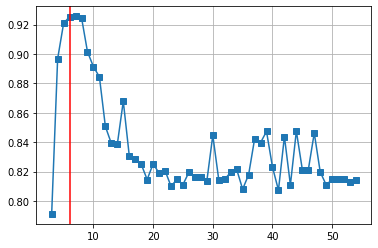

In [26]:
plt.plot(depth, r2, marker = 's')
plt.axvline(6, color='r')
plt.grid()
plt.show()

In [27]:
leafs = list(range(3, 150))
r2 = []
for d in leafs :
    m = DecisionTreeRegressor(min_samples_leaf = d, max_depth=6)
    m.fit(x_train, y_train)
    p = m.predict(x_val)
    r2.append( r2_score(y_val, p) )

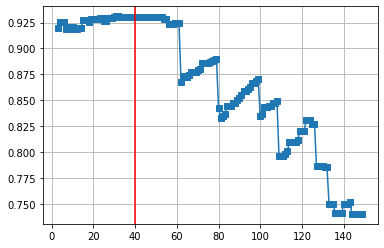

In [28]:
plt.plot(leafs, r2, marker = 's')
plt.axvline(40, color='r')
plt.grid()
plt.show()

In [29]:
model = DecisionTreeRegressor(min_samples_leaf=40, max_depth=6)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=40)

In [30]:
pred = model.predict(x_val)

In [31]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 4.031540651158345
MSE : 38.326489446105136
RMSE : 6.190839155244234
MAPE : 0.12368320745433871 

R2 Score : 0.9306718902241784
1-MAPE : 0.8763167925456613


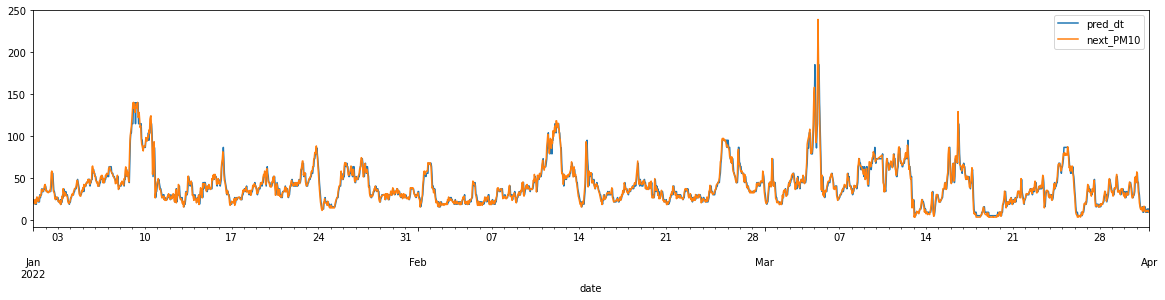

In [32]:
answer['pred_dt'] = pred
answer[['pred_dt', 'next_PM10']]['2022'].plot(figsize=(20,4))

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


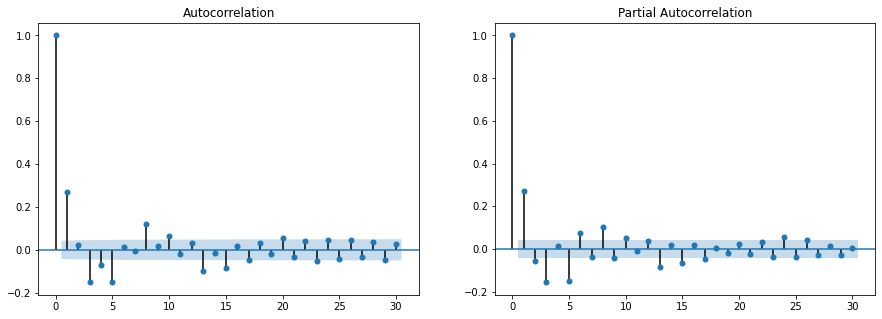

In [33]:
residual = answer['next_PM10'] - answer['pred_dt']
residual_diag(residual)

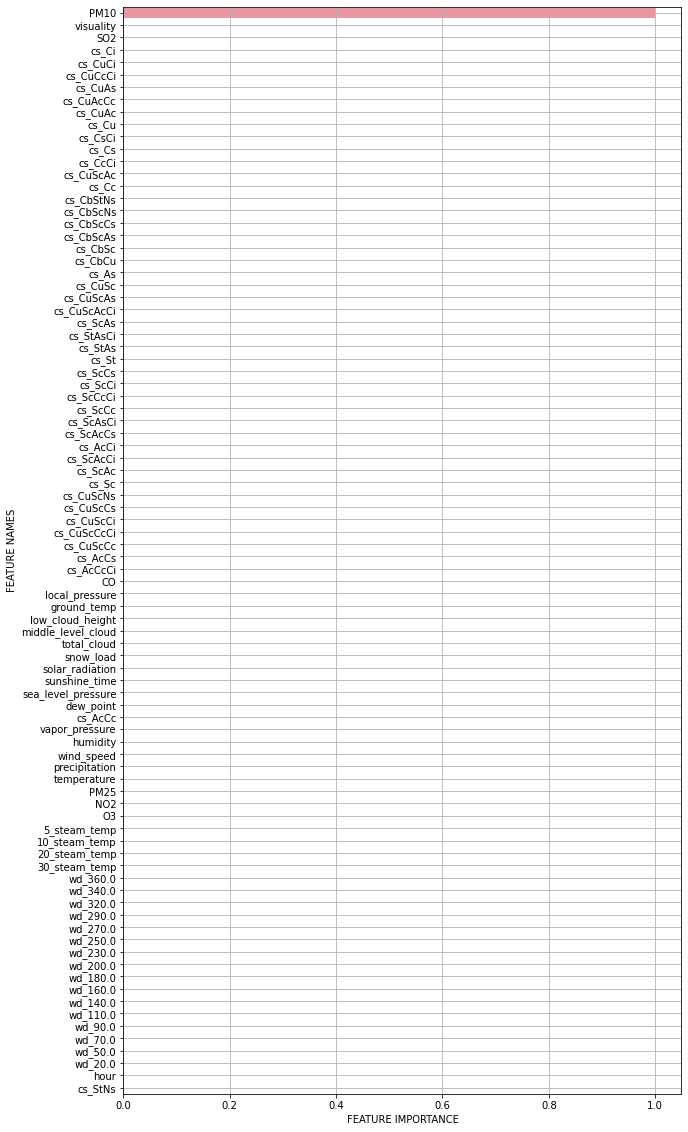

In [34]:
result = plot_feature_importance(model.feature_importances_, list(x_train))

### **RF**

In [35]:
n_estimators = list(range(100, 155, 5))
r2 = []
for n in n_estimators :
    m = RandomForestRegressor(n_estimators = n)
    m.fit(x_train, y_train)
    p = m.predict(x_val)
    r2.append( r2_score(y_val, p) )

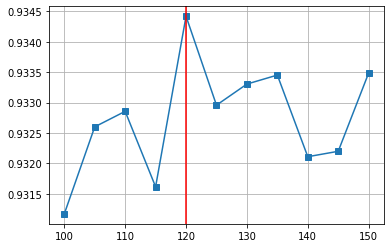

In [37]:
plt.plot(n_estimators, r2, marker = 's')
plt.axvline(120, color='r')
plt.grid()
plt.show()

In [38]:
model = RandomForestRegressor(n_estimators= 120)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=120)

In [39]:
pred = model.predict(x_val)

In [40]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 3.920855903414944
MSE : 37.23536101180335
RMSE : 6.102078417375783
MAPE : 0.12102292357792627 

R2 Score : 0.9326456131757461
1-MAPE : 0.8789770764220737


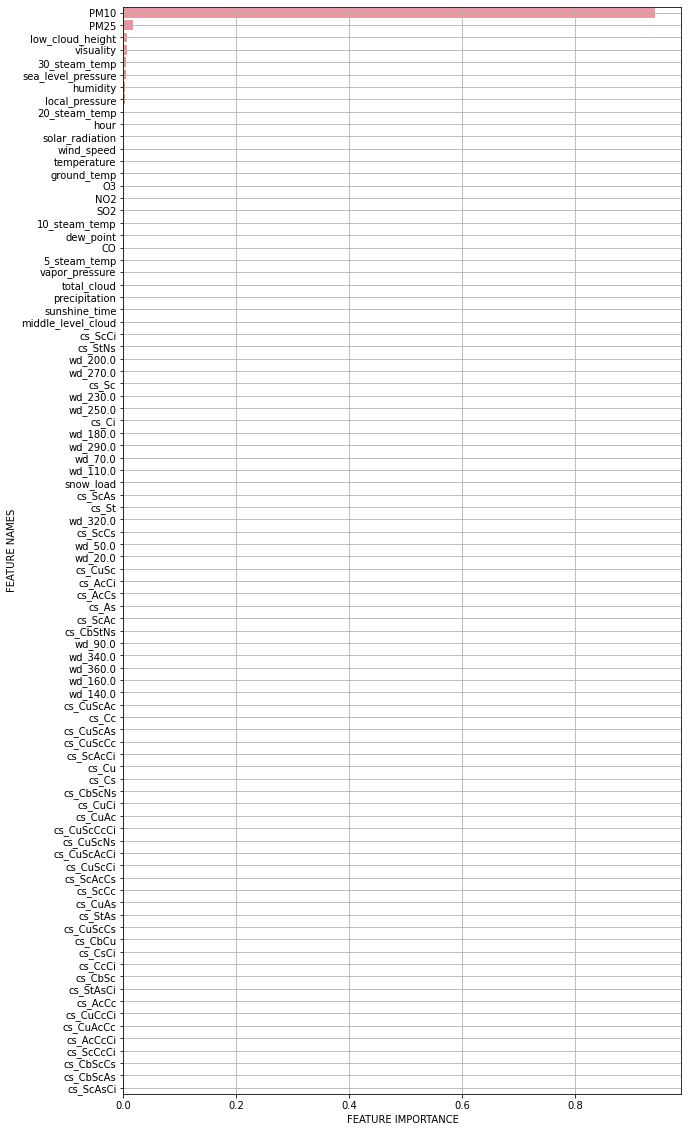

In [41]:
result = plot_feature_importance(model.feature_importances_, list(x_train))

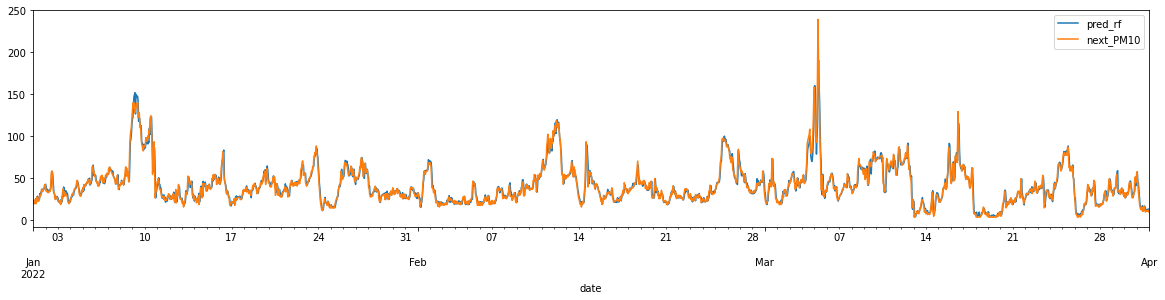

In [42]:
answer['pred_rf'] = pred
answer[['pred_rf', 'next_PM10']].plot(figsize=(20, 4))

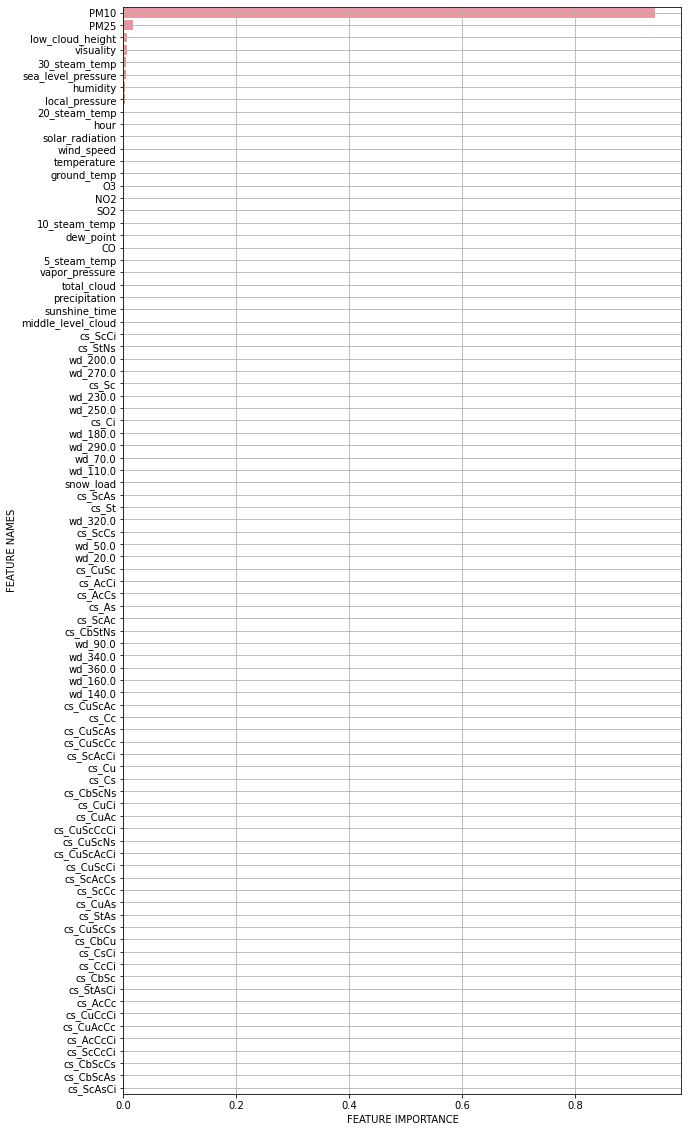

In [43]:
result = plot_feature_importance(model.feature_importances_, list(x_train))

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


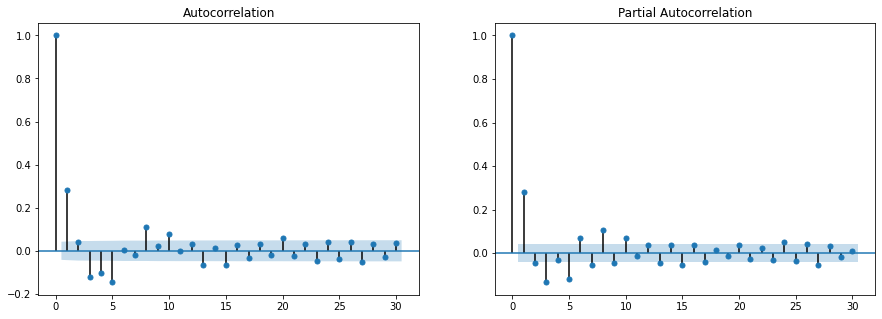

In [44]:
residual = answer['next_PM10'] - answer['pred_rf']
residual_diag(residual)

한시간 전 미세먼지 농도가 제일 중요함

### **GradientBoosting**


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=SEED)
model.fit(x_train, y_train)

pred = model.predict(x_val)

In [46]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 3.7197390110368787
MSE : 33.51181939694599
RMSE : 5.788939401733791
MAPE : 0.11901020405175222 

R2 Score : 0.9393810618317644
1-MAPE : 0.8809897959482478


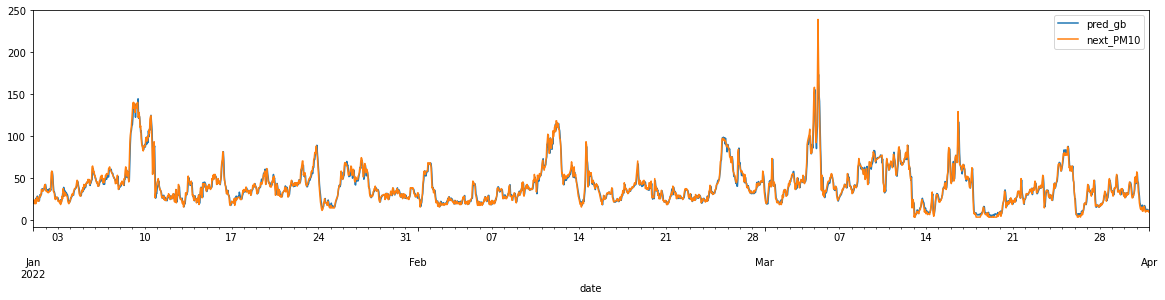

In [47]:
answer['pred_gb'] = pred
answer[['pred_gb', 'next_PM10']].plot(figsize=(20, 4))

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


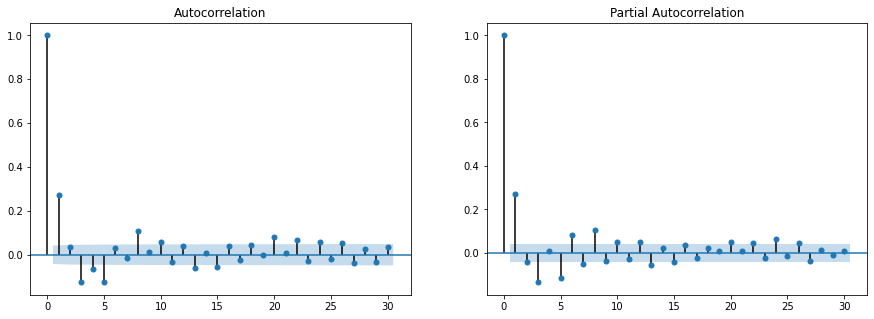

In [48]:
residual = answer['next_PM10'] - answer['pred_gb']
residual_diag(residual)

#### [실습문제6] 머신러닝_5
* 그라디언트부스팅으로 학습한 모델의 feature_importances 또는 Shap value를 구해보세요.
* 확인할 수 있는 내용으로 우리 모델에서의 인사이트를 정리해보세요.

In [49]:
model = xgboost.XGBRegressor()
model.fit(x_train, y_train)

[03:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

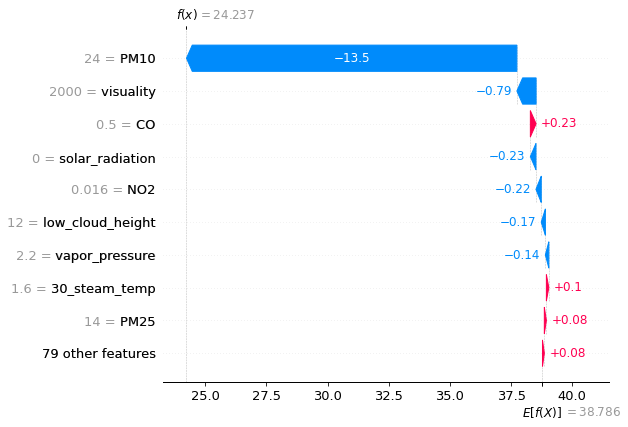

In [50]:
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

shap.plots.waterfall(shap_values[0])

In [51]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap.force_plot(explainer.expected_value, shap_values[0, :], x_train.iloc[0, :])

In [52]:
pred = model.predict(x_val)

In [53]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 3.7459165692127137
MSE : 33.10114203672589
RMSE : 5.753359195872085
MAPE : 0.12000137115302899 

R2 Score : 0.9401239288546318
1-MAPE : 0.879998628846971


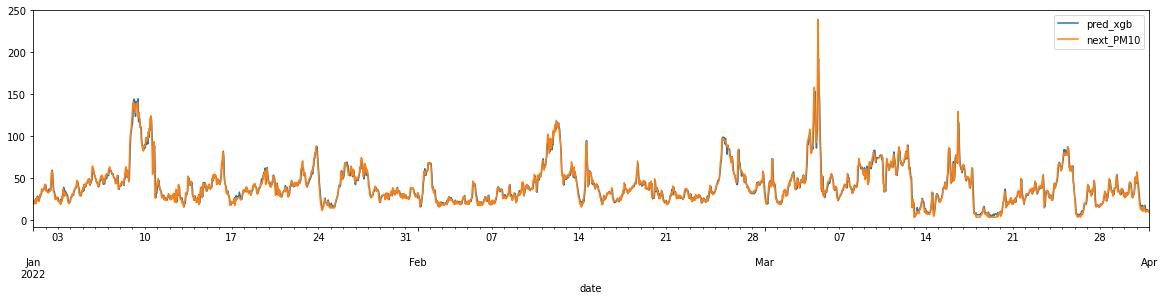

In [54]:
answer['pred_xgb'] = pred
answer[['pred_xgb', 'next_PM10']].plot(figsize=(20, 4))

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


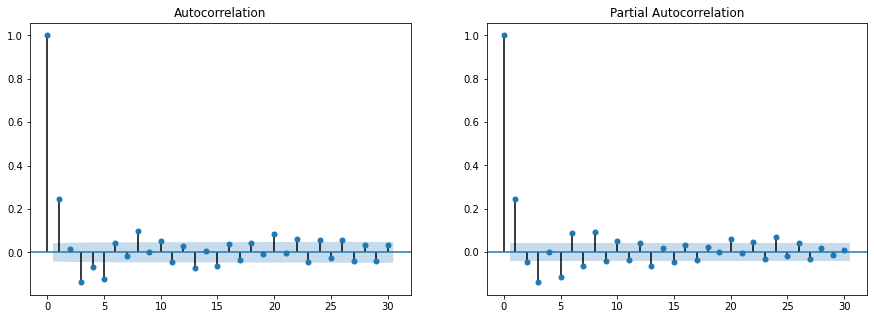

In [55]:
residual = answer['next_PM10'] - answer['pred_xgb']
residual_diag(residual)

### **SARIMAX**


In [56]:
p = [1,2,3,4]
q = [1,2,3,4]
d = [1,2]
iter = list(product(p,d,q))
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(len(y_val))
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 2, 1)
(2, 2, 2)
(2, 2, 3)
(2, 2, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 2, 1)
(3, 2, 2)
(3, 2, 3)
(3, 2, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 2, 1)
(4, 2, 2)
(4, 2, 3)
(4, 2, 4)


In [57]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
18,"(3, 1, 3)",16.390685,60589.301914


,"params(p,d,q)",mae,aic
11,"(2, 1, 4)",16.452858,60579.081927


In [59]:
P = [1,2,3]
Q = [1,2,3]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for p, d, q in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(p, d, q, 7)).fit()
    pred = model_fit.forecast(len(y_val))
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(p, d, q)

1 1 1
1 1 2
1 1 3
2 1 1
2 1 2
2 1 3
3 1 1
3 1 2
3 1 3


In [60]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
2,"(1, 1, 3)",16.340429,60604.492716


,"params(p,d,q)",mae,aic
7,"(3, 1, 2)",230891.779359,32.860271


In [61]:
m = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,3,7), exog=x_train).fit()

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


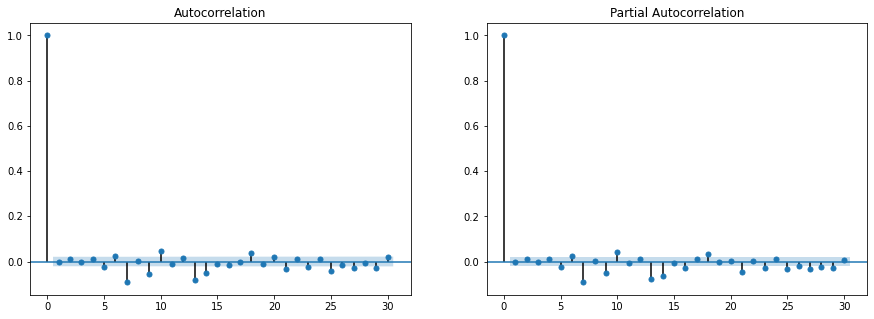

In [62]:
residuals = m.resid
residual_diag(residuals)

In [63]:
print('model AIC :', m.aic)

model AIC : 60675.61032803505


In [64]:
pred = m.forecast(len(x_val),  exog=x_val)

In [65]:
print("MAE :", mean_absolute_error(y_val, pred))
print("MSE :", mean_squared_error(y_val, pred))
print("RMSE :", mean_squared_error(y_val, pred, squared=False))
print("MAPE :", mean_absolute_percentage_error(y_val, pred), "\n")

print("R2 Score :", r2_score(y_val, pred))
print("1-MAPE :", 1 - mean_absolute_percentage_error(y_val, pred))

MAE : 9.902718663105228
MSE : 180.45183693554276
RMSE : 13.433236279301529
MAPE : 0.4983845771915388 

R2 Score : 0.6735838595938164
1-MAPE : 0.5016154228084613
